# Experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import EmpiricalCovariance, LedoitWolf

import covariance_DRO

sns.set(rc={'figure.figsize':(8,4)})

import warnings
warnings.filterwarnings("ignore")

## Synthetic Data

In [2]:
def frob(X,Y):
    return np.linalg.norm(X-Y, ord='fro')

In [3]:
def LinearShrink(emp_cov, rho):
    mu = np.trace(emp_cov) / emp_cov.shape[0]
    cov = (1. - rho) * emp_cov
    cov.flat[::emp_cov.shape[0] + 1] += rho * mu
    return cov

In [4]:
def LinearShrink2(emp_cov, rho):
    mu = np.diag(np.diag(emp_cov))
    cov = (1. - rho) * emp_cov + mu*rho
    return cov

In [5]:
def synthetic_plot(sigma, n_samples=200, n_repetitions=100, epsilons=np.logspace(-5,1,50), rhos=np.logspace(-5,0,50),error_func=frob, ax=None):
    baselines=[lambda X: EmpiricalCovariance(assume_centered=True).fit(X).covariance_,
               lambda X: LedoitWolf(assume_centered=True).fit(X).covariance_,
               lambda X, rho: LinearShrink(X, rho),
               lambda X, rho: LinearShrink2(X, rho)]
    results_b = [[], [], [], []]
    
    results = {
        'KLdirect' : [],
        'Wasserstein' : [],
        'Fisher-Rao' : []
    }
    for i in range(n_repetitions):
        # Create samples
        X = np.random.multivariate_normal(mean=[0]*(sigma.shape[0]), cov=sigma, size=n_samples)
        sigma_hat = EmpiricalCovariance(assume_centered=True).fit(X).covariance_
        # Calculate baselines error
        for j, b in enumerate(baselines[:2]):
            results_b[j].append(error_func(b(X), sigma))
        # Claculate Our Error
        for method in results.keys():
            results[method].append([])
            for e in epsilons:
                results[method][-1].append(error_func(covariance_DRO.estimate_cov(sigma_hat, e, method), sigma))
        for rho in rhos:
            results_b[2].append(error_func(baselines[2](sigma_hat, rho), sigma))
            results_b[3].append(error_func(baselines[3](sigma_hat, rho), sigma))
    
    # plot results
    data = pd.DataFrame(data = {
        'epsilons': np.tile(epsilons, n_repetitions),
        'KL' : np.array(results['KLdirect']).flatten(),
        'Wasserstein' : np.array(results['Wasserstein']).flatten(),
        'Fisher-Rao' : np.array(results['Fisher-Rao']).flatten(),
        'Sample' : np.array([[r]*len(epsilons) for r in results_b[0]]).flatten(),
        'Ledoit-Wolf' : np.array([[r]*len(epsilons) for r in results_b[1]]).flatten()
    })
    data_ls = pd.DataFrame(data = {
        'rhos': np.tile(rhos, n_repetitions),
        'Linear' : np.array(results_b[2]).flatten(), 
        'LinearDiag' : np.array(results_b[2]).flatten()
    })
    grid = sns.lineplot(x='epsilons', y='KL', data=data, label='KL', ax=ax)
    grid = sns.lineplot(x='epsilons', y='Wasserstein', data=data, label='Wasserstein', ax=ax)
    grid = sns.lineplot(x='epsilons', y='Fisher-Rao', data=data, label='Fisher-Rao', ax=ax)
    grid = sns.lineplot(x='epsilons', y='Sample', data=data, label='Sample Covariance', ax=ax)
    grid = sns.lineplot(x='epsilons', y='Ledoit-Wolf', data=data, label='Ledoit-Wolf', ax=ax)
    grid = sns.lineplot(x='rhos', y='Linear', data=data_ls, label='Linear', ax=ax)
    grid = sns.lineplot(x='rhos', y='LinearDiag', data=data_ls, label='Linear Diagonal', ax=ax)
    grid.set(xscale="log", yscale="log")
    grid.set_ylabel('Frobenius Norm of Error')
    grid.set_xlabel('Epsilon')
    return data, grid

In [6]:
def plot_multiple(sigma, ylims=None, **kwargs):
    fig, axs = plt.subplots(2,3, figsize=(18,12))
    ns = [[10000, 5000, 1000], [500, 200, 100]]
    for i in range(2):
        for j in range(3):
            d, g = synthetic_plot(sigma, n_samples=ns[i][j], ax=axs[i][j], **kwargs)
            axs[i][j].set_title('{} samples'.format(ns[i][j]))
            if ylims:
                axs[i][j].set_ylim(ylims[i][j])

In [7]:
def generate_matrix(dims=10, rho=0.95):
    sigma = np.zeros((dims, dims))
    for i in range(dims):
        for j in range(dims):
            sigma[i,j] = rho**np.abs(i-j)
    return sigma

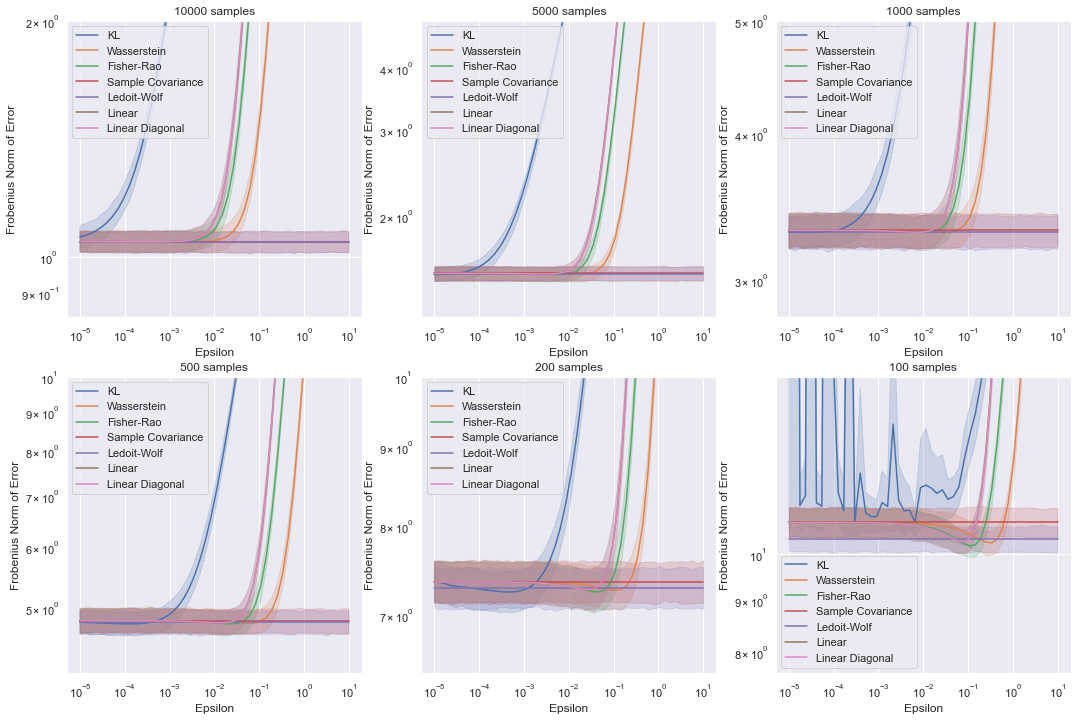

In [8]:
plot_multiple(generate_matrix(dims=100, rho=0.95), ylims=[[(None,2), (None, 5), (None, 5)],[(None, 10), (None, 10), (None, 15)]])

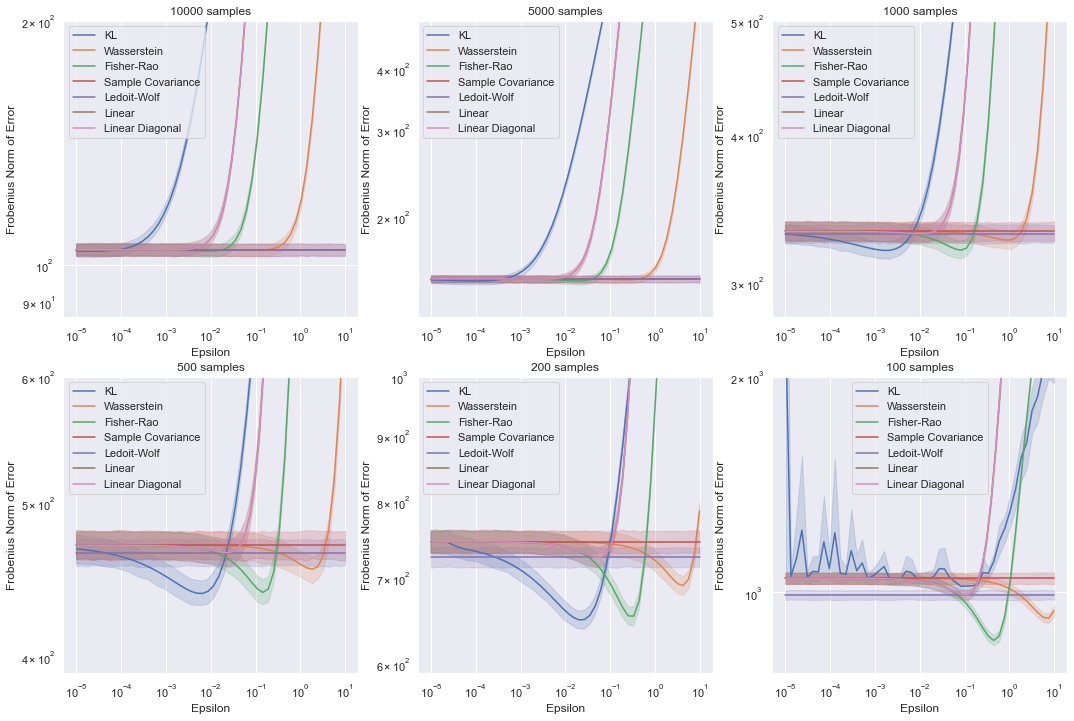

In [9]:
plot_multiple(np.diag([1]*90+[1000]*10), ylims=[[(None, 200), (None, 500), (None, 500)],[(None, 600), (None, 1000), (None, 2000)]])